In [ ]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [10]:
import os
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import xarray as xr
from cmcrameri import cm
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
from scipy.optimize import differential_evolution
from sklearn import preprocessing

sys.path.append("../")
from cfg.convert_cfg_to_yaml import save_myyaml_from_mycfg
from Data import Data_eval
import Data
from include.loss import pixel_weighted_cross_entropy
import model_eval
import models.reg as rm


import matplotlib_functions as mympf

mympf.setMatplotlibParam()
plt.viridis()

dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/res"

<Figure size 1920x1440 with 0 Axes>

In [26]:
name_model = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/best_no2"
name_model = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/8"
name_model = "/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_3_sweep/3"
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"

### On extra_valid data

In [27]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model),
    path_eval_nc,
)

model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_best.h5"
)

In [ ]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

123/197 [=================>............] - ETA: 0s

In [15]:
data.x.eval[:, :, :, -1] = np.squeeze(Data.get_seg_pred_no2(data.ds))
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

197/197 [==============================] - 1s 4ms/step
mae: 5.284111
mape: 27.577196


In [11]:
mean_metrics = model_eval.get_inv_mean_loss(data)
print("mae:", np.mean(mean_metrics["mae"]))
print("mape:", np.mean(mean_metrics["mape"]))

mae: 3.6183367
mape: 20.696836


197/197 [==============================] - 1s 4ms/step


<Figure size 1920x1440 with 0 Axes>

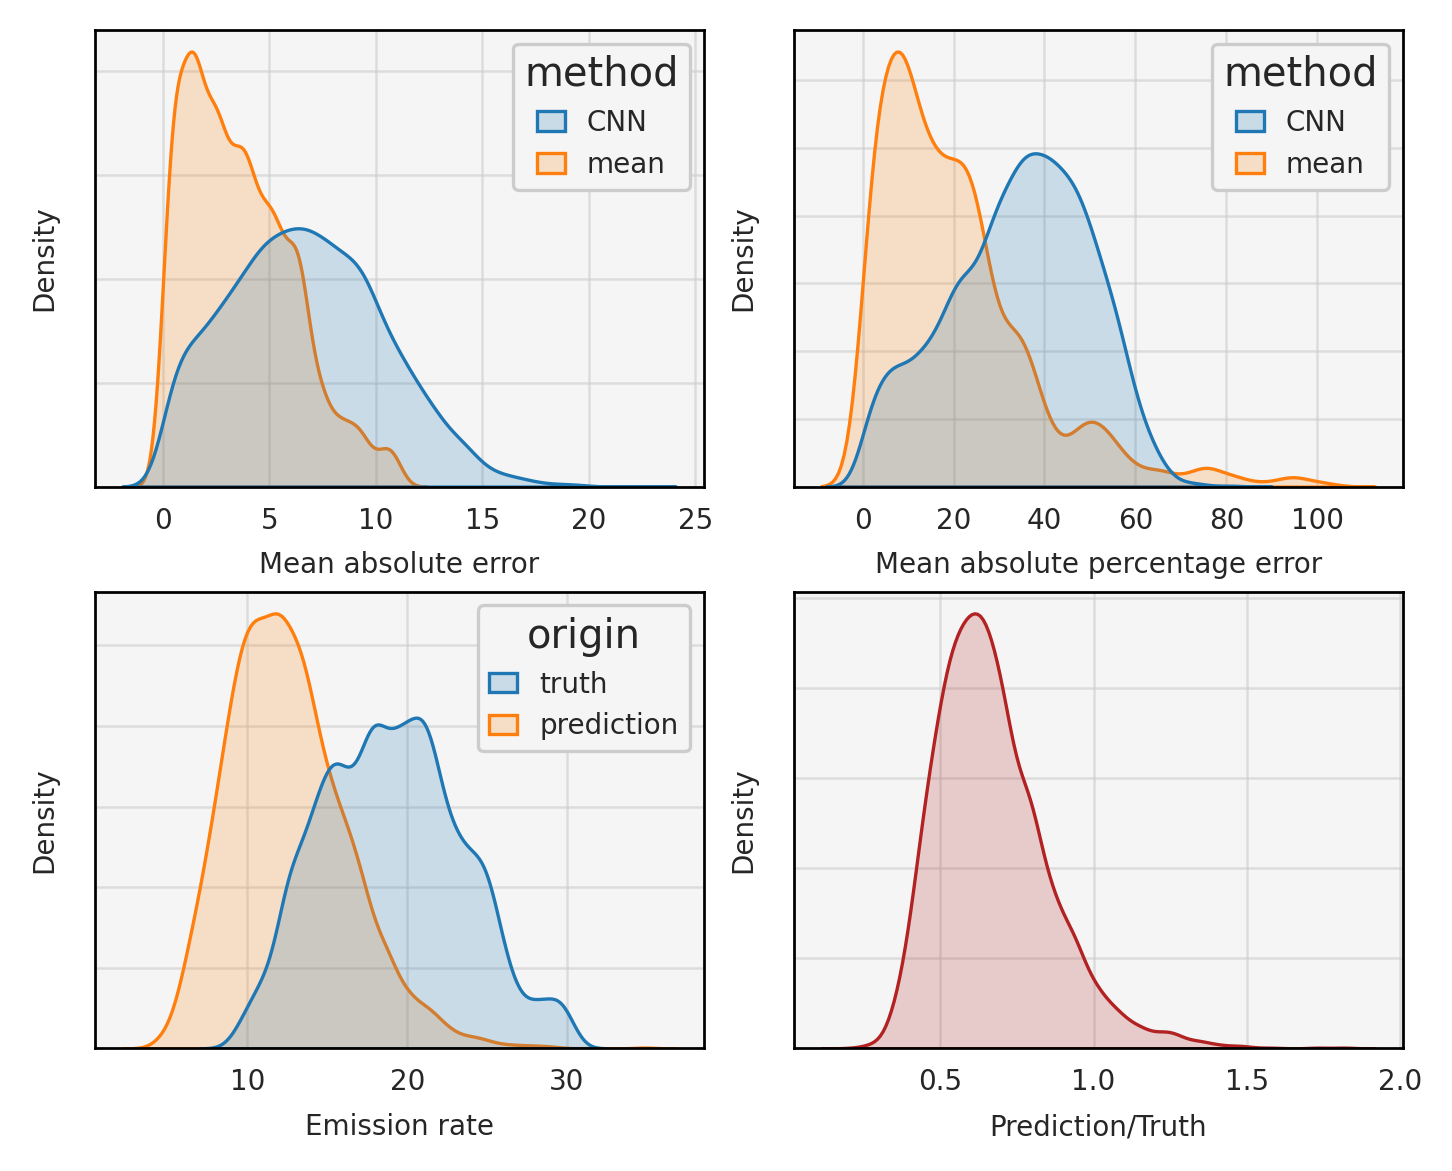

In [21]:
model_eval.get_summary_histo_inversion(model, data)

nwbce: 7.415631294250488
idx: 3711
origin: smart_2km_Box_64
time: 2015-07-30T15:00:00.000000000
emiss: [19.53834 19.88408 20.92147]

nwbce: 2.2842636108398438
idx: 1833
origin: smart_2km_Box_64
time: 2015-04-15T09:00:00.000000000
emiss: [24.44602 21.641   16.03076]

nwbce: 7.142918586730957
idx: 5387
origin: smart_2km_Box_64
time: 2015-11-01T11:00:00.000000000
emiss: [19.28361 19.44305 17.21215]

1/1 [==============================] - 0s 16ms/step


<Figure size 1920x1440 with 0 Axes>

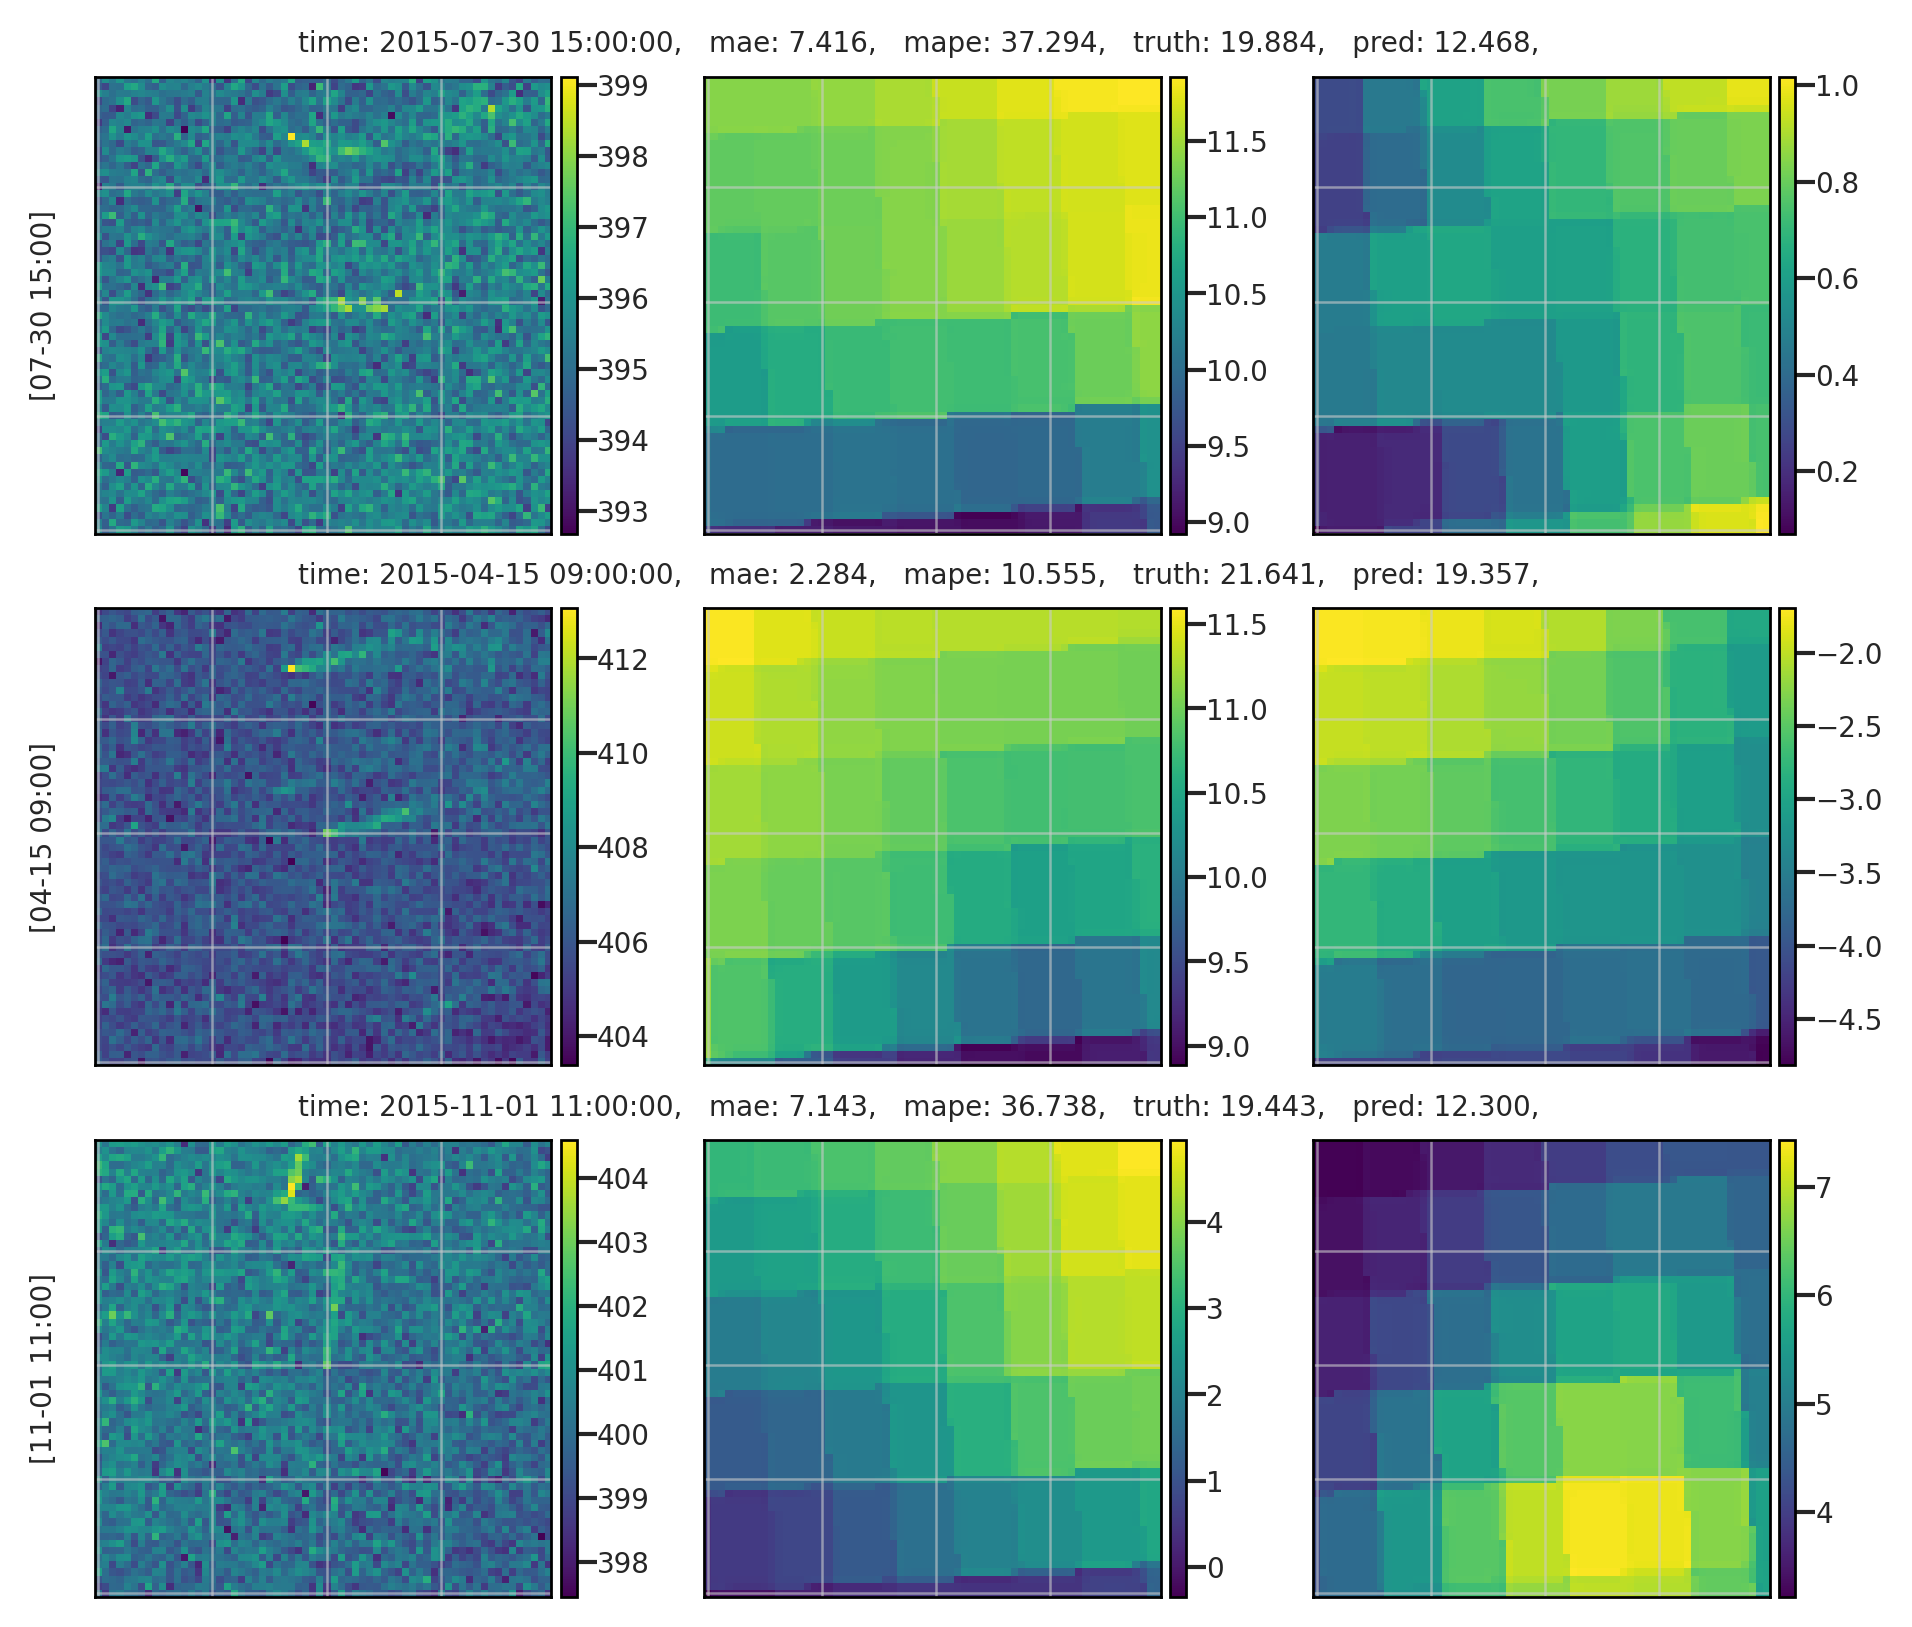

In [22]:
model_eval.plot_inversion_examples(data, metrics["mae"], metrics["mape"], model)

### On validation dataset

In [23]:
data_val = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model),
    path_valid_nc,
)

In [24]:
metrics_val = model_eval.get_inv_metrics_model_on_data(model, data_val)
print("mae:", np.mean(metrics_val["mae"]))
print("mape:", np.mean(metrics_val["mape"]))

144/144 [==============================] - 1s 5ms/step
mae: 2.726034
mape: 23.013462


144/144 [==============================] - 1s 5ms/step


<Figure size 1920x1440 with 0 Axes>

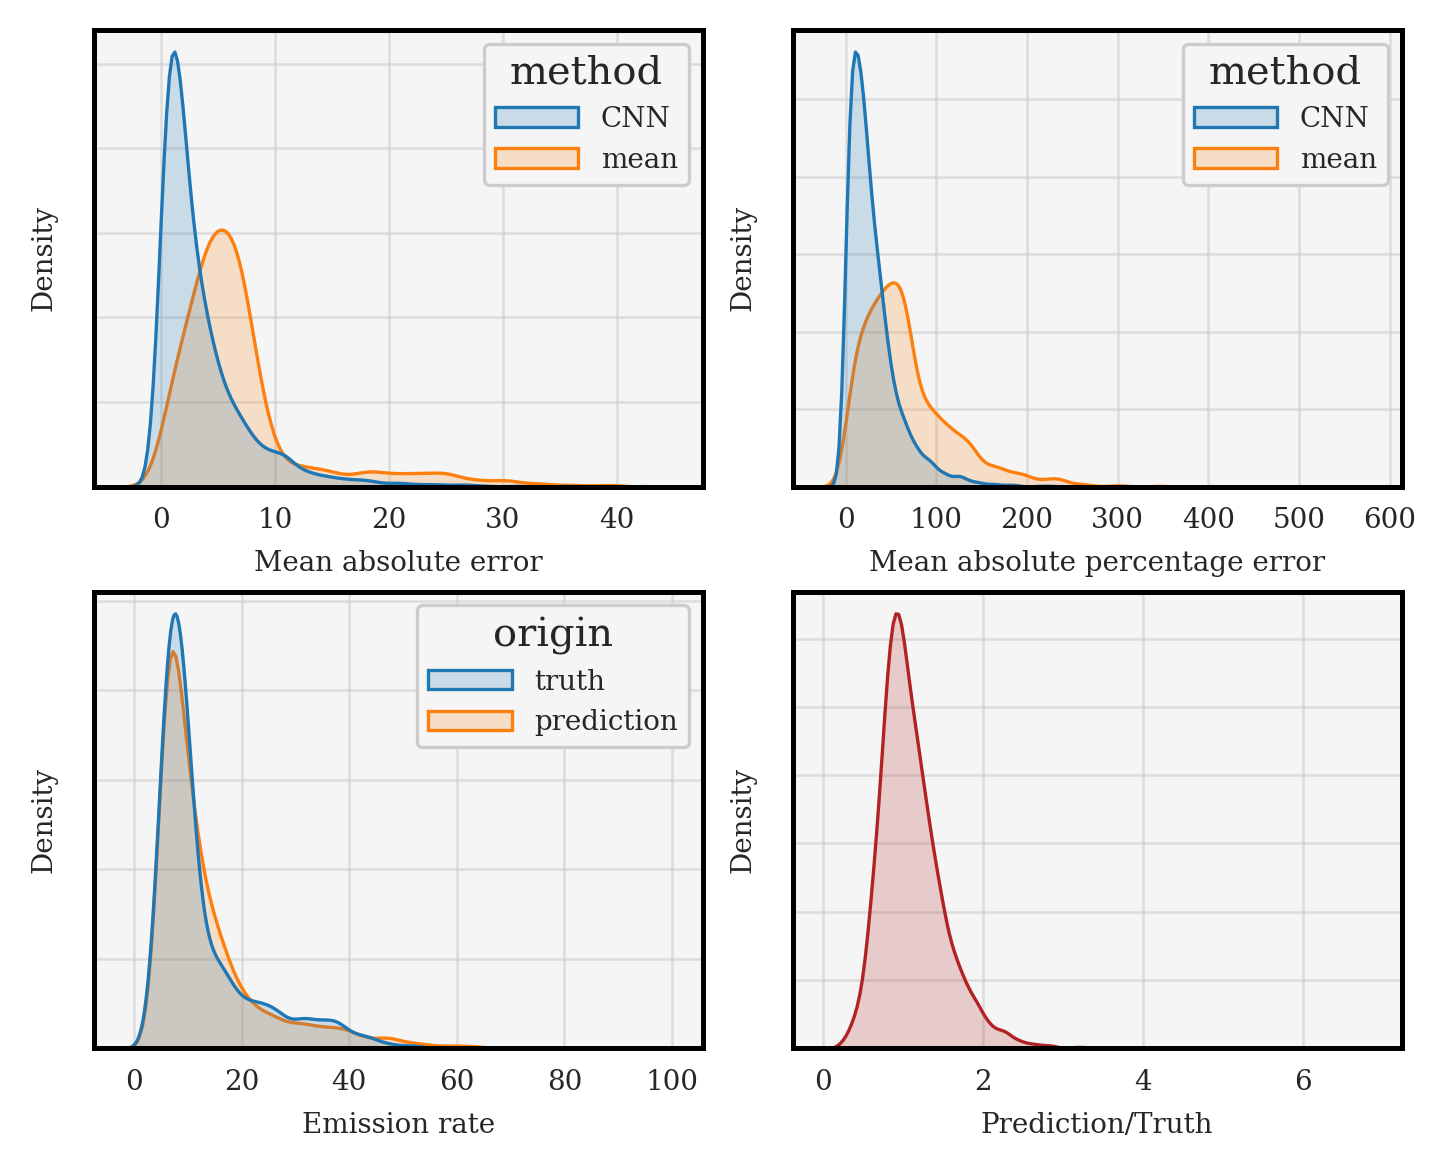

In [11]:
model_eval.get_summary_histo_inversion(model, data_val)

nwbce: 4.816732406616211
idx: 3397
origin: smart_2km_Lip_64
time: 2015-11-22T03:00:00.000000000
emiss: [ 9.059783  9.187235 12.39877 ]

nwbce: 2.2420687675476074
idx: 1993
origin: smart_2km_Opo_64
time: 2015-06-21T03:00:00.000000000
emiss: [4.069144 3.611352 4.050529]

nwbce: 3.547396183013916
idx: 2049
origin: smart_2km_Opo_64
time: 2015-07-21T19:00:00.000000000
emiss: [6.600558 6.665959 6.992798]

1/1 [==============================] - 0s 16ms/step


<Figure size 1920x1440 with 0 Axes>

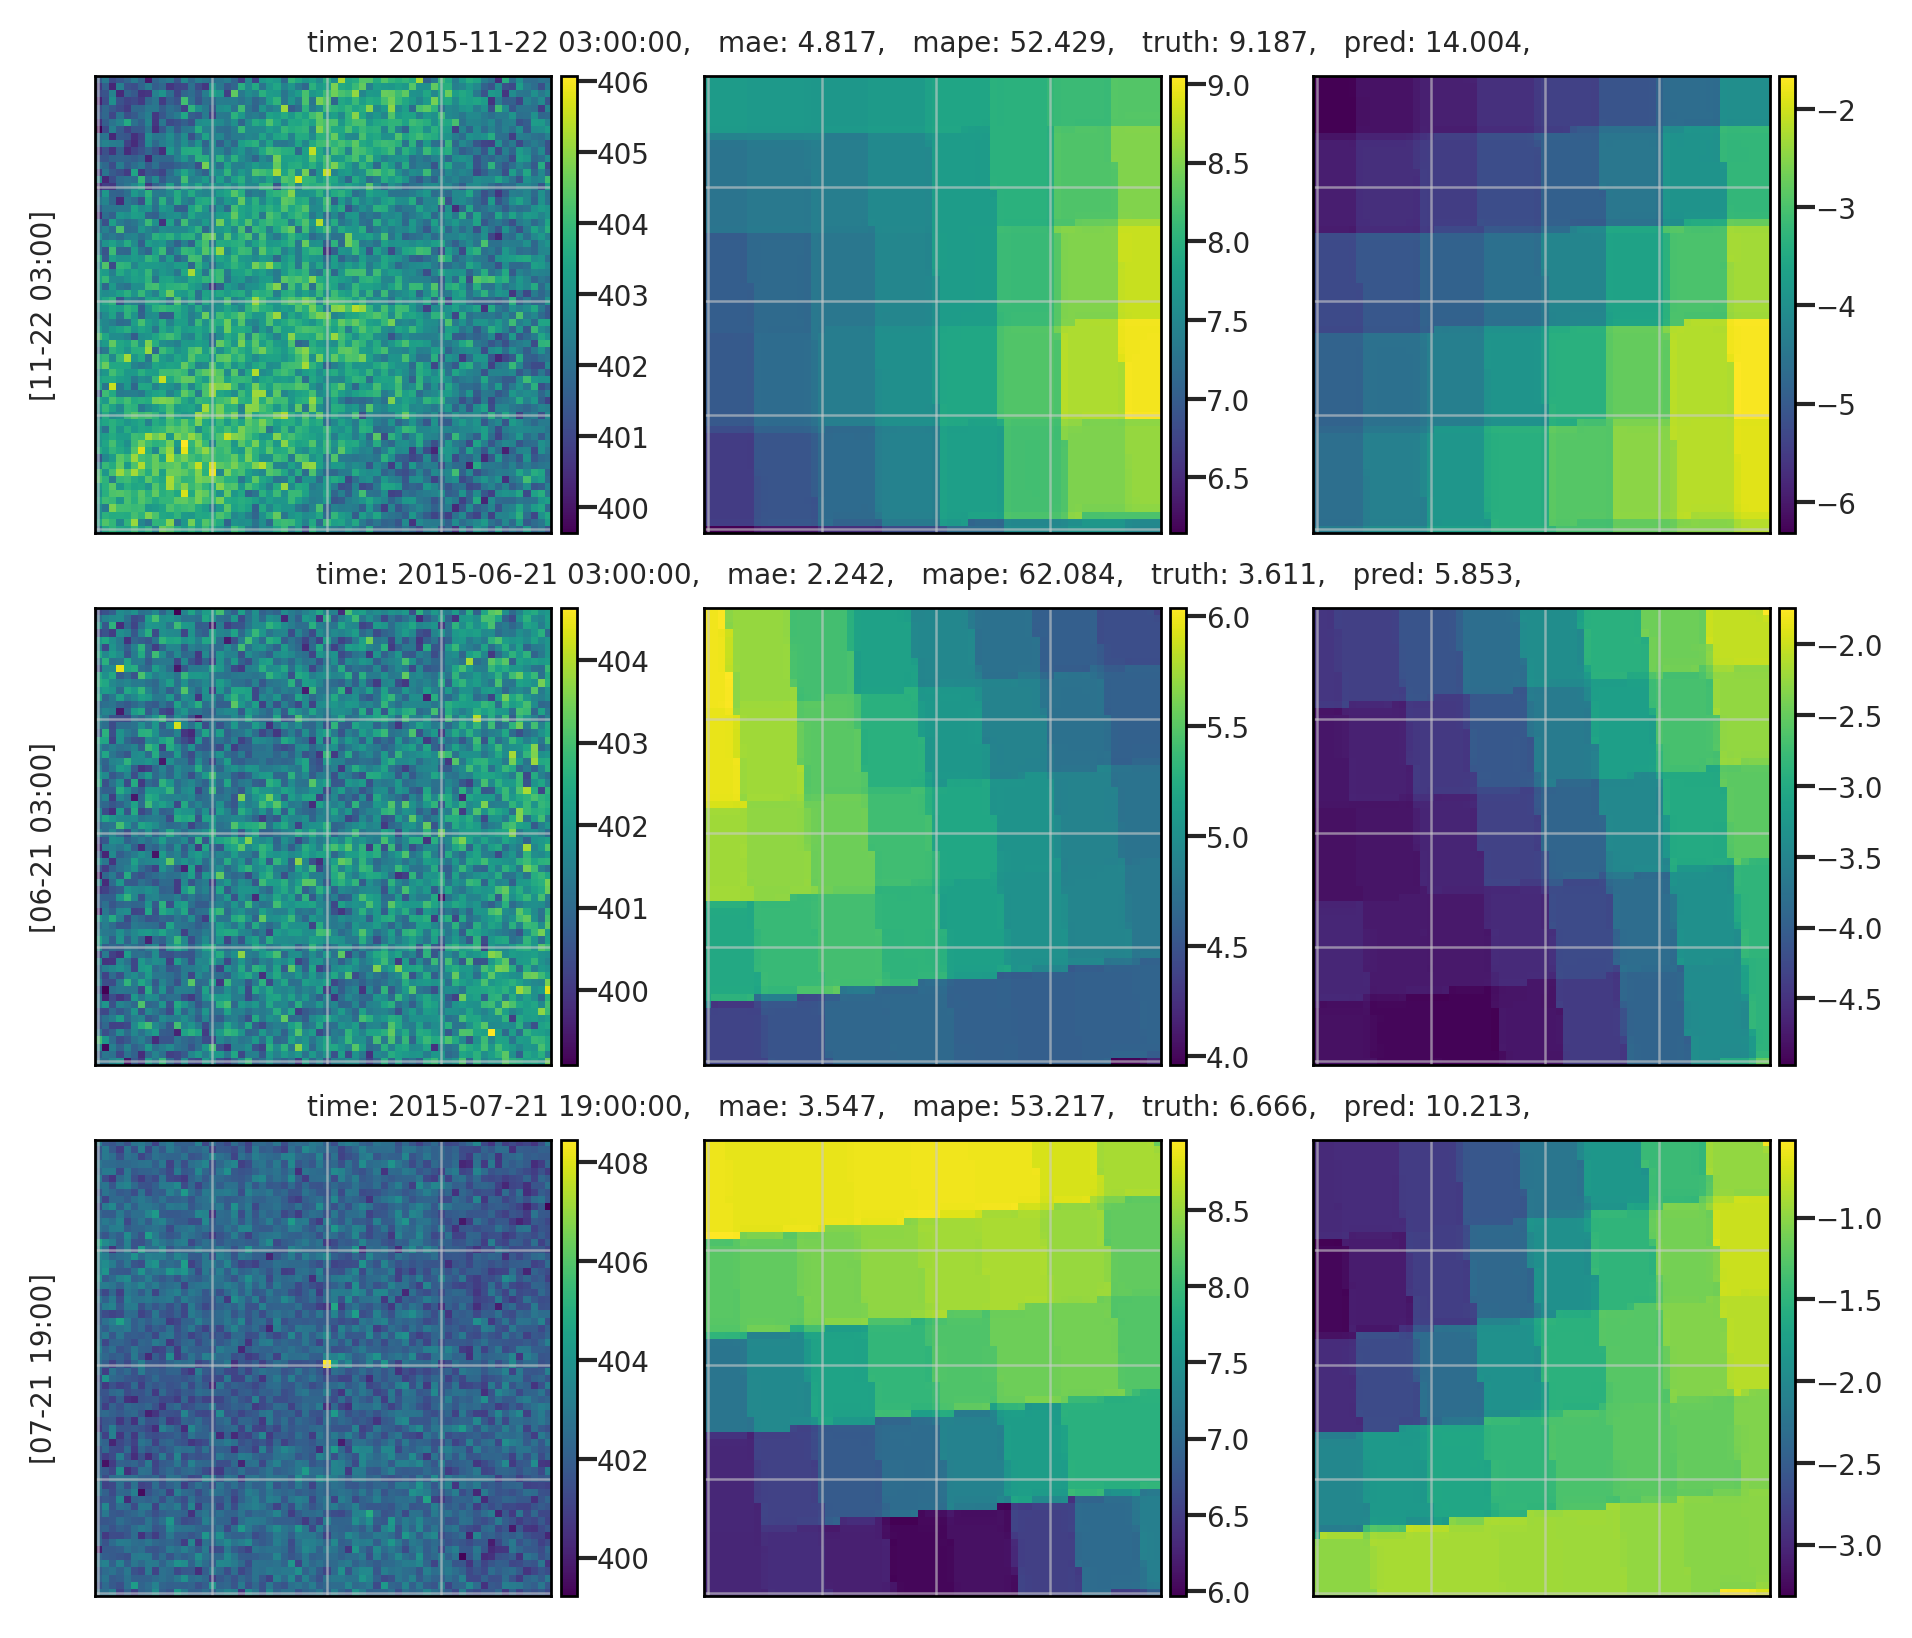

In [25]:
model_eval.plot_inversion_examples(
    data_val, metrics_val["mae"], metrics_val["mape"], model
)

## TESTS

In [11]:
plume = np.expand_dims(data.ds.plume.values, -1)
back = np.expand_dims(data.ds.xco2_back.values, -1)

### Gradient based method

tf.Tensor(6.080416817073037, shape=(), dtype=float64)


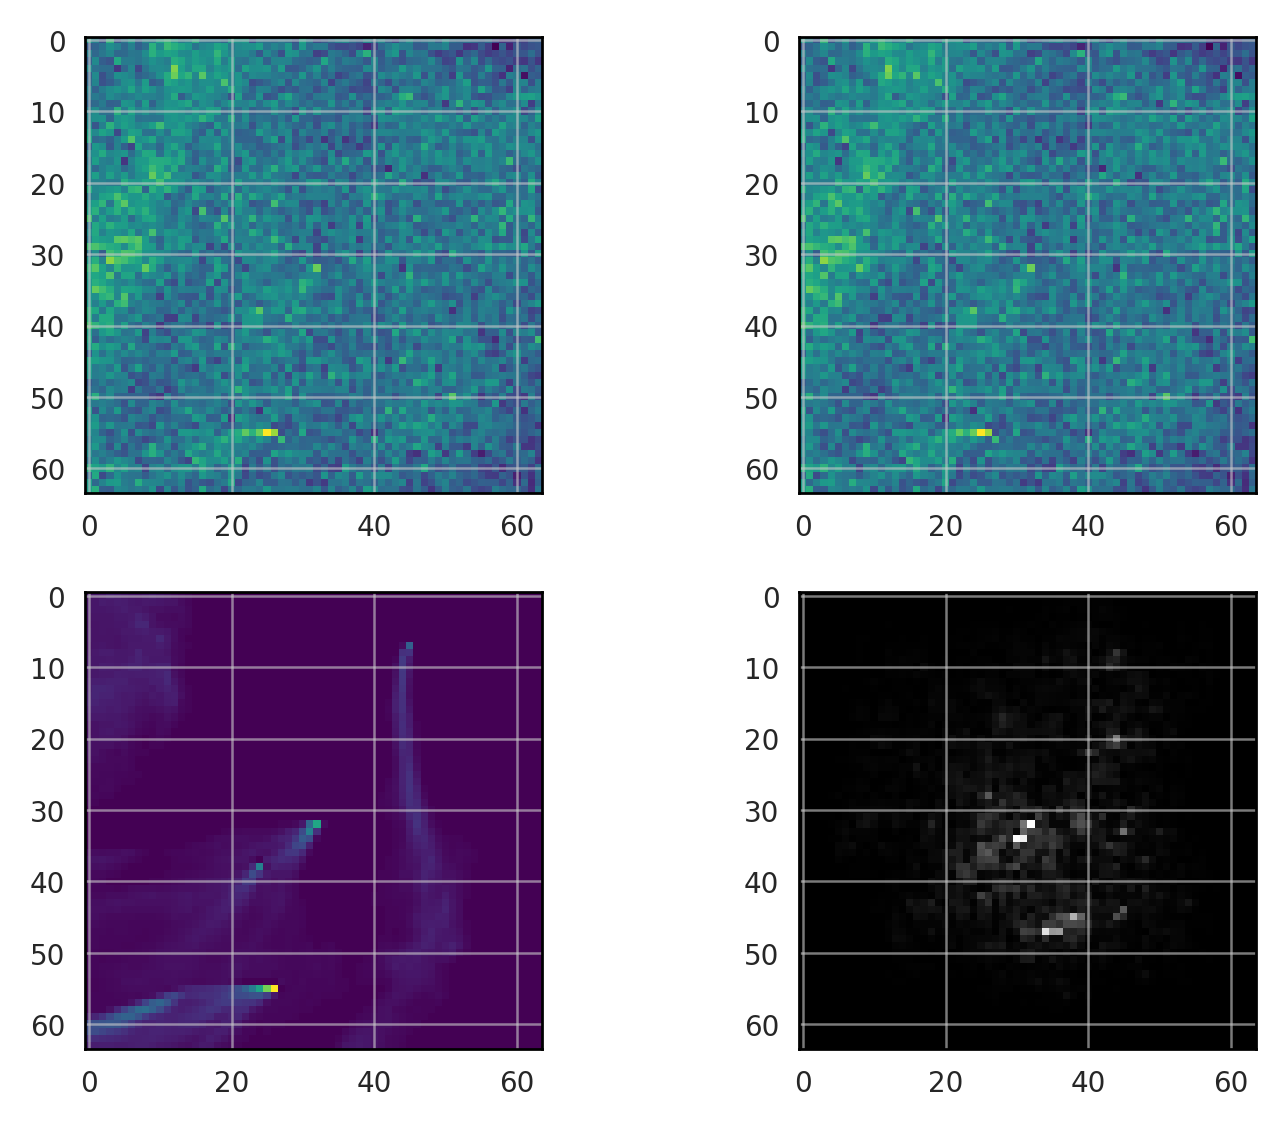

In [17]:
idx = np.random.choice(data.ds.attrs["N_img"])
x = data.x.eval[idx : idx + 1]
y = data.y.eval[idx : idx + 1]
x = tf.cast(x, tf.float32)  # Convert to float32


# Define loss function
loss_function = tf.keras.losses.MeanAbsolutePercentageError()
print(loss_function(model(x), y))

# Define gradient function
@tf.function
def get_gradients(input_image, model, loss_function, target):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        loss = loss_function(predictions, target)
    gradients = tape.gradient(loss, input_image)
    return gradients


# Compute gradient-based feature importance
gradients = get_gradients(x, model, loss_function, y)
importance = tf.reduce_max(tf.abs(gradients), axis=-1)

axs = mympf.set_figure_axs(2, 2)
axs[0].imshow(np.squeeze(data.x.eval[idx, :, :, 0]))
axs[1].imshow(np.squeeze(data.x.eval[idx, :, :, 1]))
axs[2].imshow(np.squeeze(plume[idx, :, :, 0]))
axs[3].imshow(np.squeeze(importance.numpy()), cmap="gray")
plt.show()

In [11]:
baseline_tensor = tf.zeros_like(x)

In [12]:
def integrated_gradients(model, img_tensor, baseline_tensor, num_steps=100):
    # Define the path from baseline to input as a straight line
    alphas = tf.linspace(start=0.0, stop=1.0, num=num_steps + 1)

    # Compute the gradients of the model's output with respect to the input
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
    grads = tape.gradient(predictions, img_tensor)

    # Compute the gradient at each point along the path
    interpolated_inputs = [
        (baseline_tensor + alpha * (img_tensor - baseline_tensor)) for alpha in alphas
    ]
    interpolated_inputs = tf.stack(interpolated_inputs)
    interpolated_inputs = tf.reshape(
        interpolated_inputs, [-1] + list(img_tensor.shape[1:])
    )
    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        interpolated_predictions = model(interpolated_inputs)
    interpolated_grads = tape.gradient(interpolated_predictions, interpolated_inputs)

    # Approximate the integral using the trapezoidal rule
    avg_grads = tf.reduce_mean(interpolated_grads, axis=0)
    integrated_grads = tf.reduce_sum(avg_grads * (img_tensor - baseline_tensor), axis=0)
    return integrated_grads

In [27]:
idx = np.random.choice(data.ds.attrs["N_img"])
alt_idx = np.random.choice(data.ds.attrs["N_img"])
x = tf.cast(data.x.eval[idx : idx + 1], tf.float32)
y = data.y.eval[idx : idx + 1]
baseline_tensor = tf.cast(back[alt_idx : alt_idx + 1], tf.float32)
baseline_tensor = tf.zeros_like(x)

integ_grad = integrated_gradients(model, x, baseline_tensor)

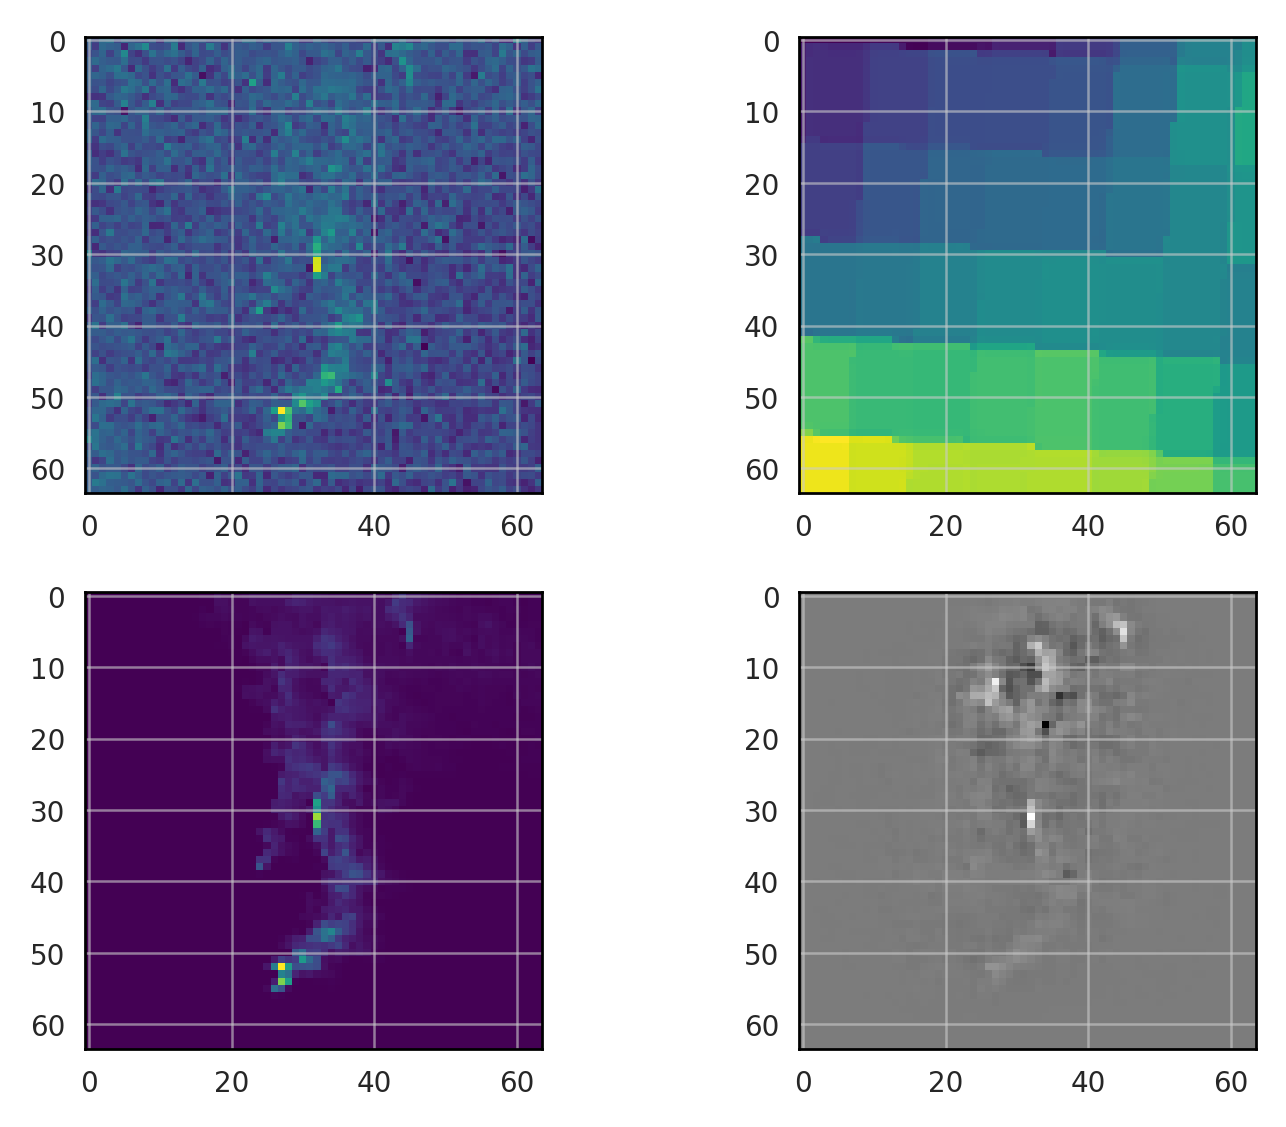

0.95784914


In [28]:
axs = mympf.set_figure_axs(2, 2)
axs[0].imshow(np.squeeze(data.x.eval[idx, :, :, 0]))
axs[1].imshow(np.squeeze(data.x.eval[idx, :, :, 1]))
axs[2].imshow(np.squeeze(plume[idx, :, :, 0]))
axs[3].imshow(np.squeeze(integ_grad.numpy()[:, :, 0]), cmap="gray")
plt.show()
print((metrics["mape"][idx] / np.median(metrics["mape"])).numpy())

- gradient importance when bad scores
- feature importance permutation
- Residual analysis: Analyze the residuals (difference between true values and predicted values) to check if there are patterns in the errors that the model is making. For example, if the residuals are normally distributed, it indicates that the model is making random errors.

### Feature importance

In [ ]:
from sklearn.inspection import permutation_importance

In [394]:
X = data.x.eval

In [405]:
height, width, channels = X.shape[1:]

In [451]:
import itertools

In [486]:
def channel_permutation_importance(
    X,
    y,
    model,
    channel_axis=-1,
    num_permutations=10,
    loss_function=tf.keras.losses.MeanAbsolutePercentageError(),
):
    # Get image shape
    height, width, channels = X.shape[1:]

    # Compute baseline predictions
    baseline_predictions = model(X)
    baseline_loss = loss_function(y, baseline_predictions).numpy()

    my_list = [i for i in range(channels)]
    
    combinations = []
    for r in range(1, len(my_list) + 1):
        for combo in itertools.combinations(my_list, r):
            combinations.append(combo)

    # Compute feature importances
    importances = np.zeros(len(combinations))

    for i, perm in enumerate(combinations):
        X_permuted = np.copy(X)
        for p in perm:
            X_permuted[:, :, :, p] = np.random.permutation(X[:, :, :, p])

        # Compute predictions with permuted channel
        permuted_predictions = model(X_permuted)
        permuted_loss = loss_function(y, permuted_predictions).numpy()

        # Compute feature importance for channel
        importances[i] = baseline_loss - permuted_loss
        print(perm, importances[i])

    return importances

In [487]:
importances = channel_permutation_importance(X, y, model)

(0,) -2.0457515716552734
(1,) -1.8784427642822266
(2,) -2.497631072998047
(3,) -9.18198013305664
(0, 1) -9.20718765258789
(0, 2) -4.122749328613281
(0, 3) -7.349452972412109
(1, 2) -4.058040618896484
(1, 3) -7.766544342041016
(2, 3) -11.146942138671875
(0, 1, 2) -9.592628479003906
(0, 1, 3) -8.961124420166016
(0, 2, 3) -9.397281646728516
(1, 2, 3) -8.626197814941406
(0, 1, 2, 3) -9.280647277832031
